In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path,filter='fully_trusted')
    housing_tgz.close()

fetch_housing_data()

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

import numpy as np
np.random.seed(42)
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing_num = housing.drop("ocean_proximity", axis=1)

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = {
    LinearRegression(): [{'fit_intercept' : [True,False], 'copy_X' : [True, False]}],
    RandomForestRegressor(): [{'n_estimators': [3, 10, 30,100], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ],
    SVR(): [
    {'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000]},
    {'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}  
]
}

for model, model_param in models.items():
    model.fit(housing_prepared, housing_labels)

    grid_search = GridSearchCV(model, model_param, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(housing_prepared, housing_labels)

    print(f"Model: {type(model).__name__}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print("-" * 40)


Model: LinearRegression
Best Parameters: {'copy_X': True, 'fit_intercept': True}
----------------------------------------
Model: RandomForestRegressor
Best Parameters: {'max_features': 8, 'n_estimators': 100}
----------------------------------------
Model: SVR
Best Parameters: {'C': 1000, 'kernel': 'linear'}
----------------------------------------


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random



models = {
    LinearRegression(): [{'fit_intercept' : [True,False], 'copy_X' : [True, False]}],
    RandomForestRegressor(): [{'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=8)},
 {'bootstrap': [False], 'n_estimators': randint(low=1, high=200), 'max_features': randint(low=1, high=8)},
 ],
    SVR(): [
    {'kernel': ['linear'], 'C': randint(low=1, high=1000)},
    {'kernel': ['rbf'], 'C': randint(low=1, high=1000), 'gamma': [0.001, 0.01, 0.1, 1]}
]
}

for model, model_param in models.items():
    model.fit(housing_prepared, housing_labels)

    rand_search = RandomizedSearchCV(model, param_distributions=model_param,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
    rand_search.fit(housing_prepared, housing_labels)
    print(f"Model: {type(model).__name__}")
    print(f"Best Parameters: {rand_search.best_params_}")
    print("-" * 40)

Model: RandomForestRegressor
Best Parameters: {'max_features': 5, 'n_estimators': 100}
----------------------------------------
Model: SVR
Best Parameters: {'C': 459, 'kernel': 'linear'}
----------------------------------------


In [74]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

print("Grid search")

models = {
    "Linear Regression": LinearRegression(copy_X=True,fit_intercept=True),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(max_features=8, n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel="linear", C=1000)
}


for model_name, model in models.items():
    model.fit(housing_prepared, housing_labels)
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print(f"\nModel: {model_name}")
    display_scores(rmse_scores)

Grid search

Model: Linear Regression
Mean: 69204.32275494764
Standard deviation: 2372.070791055923

Model: Decision Tree
Mean: 69004.0363929806
Standard deviation: 2305.582135983226

Model: Random Forest
Mean: 48883.90236633153
Standard deviation: 2018.515849579816

Model: Support Vector Regressor
Mean: 70488.58334087554
Standard deviation: 2506.6038520816137


In [64]:
models = {
    "Linear Regression": LinearRegression(copy_X=True,fit_intercept=True),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(max_features=5, n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel="linear", C=459)
}

print("Random search")


for model_name, model in models.items():
    model.fit(housing_prepared, housing_labels)
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print(f"\nModel: {model_name}")
    display_scores(rmse_scores)


Model: Linear Regression
Mean: 69204.32275494764
Standard deviation: 2372.070791055923

Model: Decision Tree
Mean: 69089.71589947978
Standard deviation: 2295.9348630836635

Model: Random Forest
Mean: 49192.637183445855
Standard deviation: 2123.650967811714

Model: Support Vector Regressor
Mean: 70626.36024377828
Standard deviation: 2522.5986896115387


In [40]:
param_grid = [
    {'n_estimators': [30], 'max_features': [8]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [8], 'n_estimators': [30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [42]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.05784555e-01, 9.77608475e-02, 5.05551584e-02, 3.04116971e-02,
       2.69356863e-02, 4.06259319e-02, 2.63850940e-02, 4.51422930e-01,
       1.04299655e-02, 1.53177272e-01, 1.56358159e-05, 1.59417083e-03,
       4.90105654e-03])

In [47]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.4514229299024066), 'median_income'),
 (np.float64(0.15317727159098957), 'pop_per_hhold'),
 (np.float64(0.10578455467355673), 'longitude'),
 (np.float64(0.09776084745397101), 'latitude'),
 (np.float64(0.050555158353914685), 'housing_median_age'),
 (np.float64(0.04062593190523444), 'population'),
 (np.float64(0.030411697118467453), 'total_rooms'),
 (np.float64(0.026935686293612923), 'total_bedrooms'),
 (np.float64(0.02638509400288614), 'households'),
 (np.float64(0.010429965515030308), 'rooms_per_hhold'),
 (np.float64(0.004901056539401569), 'INLAND'),
 (np.float64(0.0015941708346023545), '<1H OCEAN'),
 (np.float64(1.5635815926181506e-05), 'bedrooms_per_room')]

In [49]:
from sklearn.metrics import mean_squared_error
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [50]:
final_rmse

np.float64(47859.544319108194)

In [51]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45909.04350565, 49733.6072416 ])

In [62]:
some_data = housing.iloc[:5]

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("Random Forest", RandomForestRegressor(max_features=6, n_estimators=30, random_state=42))
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 73466.66666667, 295086.66666667,  79750.        , 119706.66666667,
       225770.        ])

In [58]:
my_model = full_pipeline_with_predictor

In [63]:
import joblib
joblib.dump(my_model, "my_model.pkl")

['my_model.pkl']

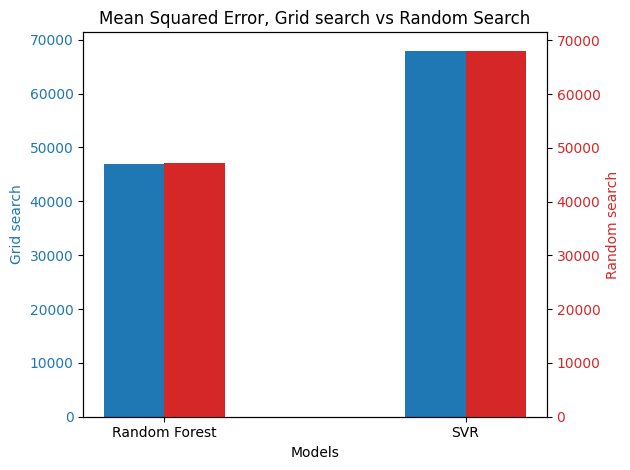

[np.float64(46865.386516751714), np.float64(67981.97948879394)] [np.float64(47107.94767967084), np.float64(68103.76155416675)]


In [72]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

models_grid = {
    "Random Forest": RandomForestRegressor(max_features=8, n_estimators=100, random_state=42),
    "SVR": SVR(kernel="linear", C=1000)
}

models_random = {
    "Random Forest": RandomForestRegressor(max_features=6, n_estimators=100, random_state=42),
    "SVR": SVR(kernel="linear", C=459)
}

grid_results = []
random_results = []
for model_name, model in models_grid.items():
    model.fit(housing_prepared, housing_labels)
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    grid_results.append(rmse_scores.mean()-rmse_scores.std())

for model_name, model in models_random.items():
    model.fit(housing_prepared, housing_labels)
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    random_results.append(rmse_scores.mean()-rmse_scores.std())



x = np.arange(len(models_grid))
width = 0.20 
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Models')
ax1.set_ylabel('Grid search', color=color)
bars1 = ax1.bar(x - width/2, grid_results, width, label='MSE', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Random search', color=color)
bars2 = ax2.bar(x + width/2, random_results, width, label='Fit Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(x)
ax1.set_xticklabels(models_grid.keys())

plt.title('Mean Squared Error, Grid search vs Random Search')
fig.tight_layout() 
plt.show()

print(grid_results, random_results)